In [1]:
!pip install xgboost hyperopt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importing Libraries  
from functools import reduce
import gc  
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe 
from IPython.display import display, HTML  
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go 
import plotly.offline as py 
from plotly.subplots import make_subplots 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import MinMaxScaler  
import seaborn as sns 
import warnings 
from xgboost import XGBRegressor  

py.init_notebook_mode(connected = True)  
pd.set_option('display.max_columns', None)  
warnings.filterwarnings('ignore')  

HTML("""
<style>
g.pointtext {display: none;}
</style>
""")

In [3]:
# Read All Datasets 
rating_df = pd.read_csv('MarchMadnessData/538 Ratings.csv')
ban_df = pd.read_csv('MarchMadnessData/Barttorvik Away-Neutral.csv')
ba_df = pd.read_csv('MarchMadnessData/Barttorvik Away.csv')
bh_df = pd.read_csv('MarchMadnessData/Barttorvik Home.csv')
bn_df = pd.read_csv('MarchMadnessData/Barttorvik Neutral.csv')
coach_res_df = pd.read_csv('MarchMadnessData/Coach Results.csv')
conf_res_df = pd.read_csv('MarchMadnessData/Conference Results.csv')
cs_df = pd.read_csv('MarchMadnessData/Conference Stats.csv')
csh_df = pd.read_csv('MarchMadnessData/Conference Stats Home.csv')
csa_df = pd.read_csv('MarchMadnessData/Conference Stats Away.csv')
csn_df = pd.read_csv('MarchMadnessData/Conference Stats Neutral.csv')
csan_df = pd.read_csv('MarchMadnessData/Conference Stats Away Neutral.csv')
hcti_df = pd.read_csv('MarchMadnessData/Heat Check Tournament Index.csv')
kb_df = pd.read_csv('MarchMadnessData/KenPom Barttorvik.csv')  
pv_df = pd.read_csv('MarchMadnessData/Preseason Votes.csv')
pp_df = pd.read_csv('MarchMadnessData/Public Picks.csv')
r_df = pd.read_csv('MarchMadnessData/Resumes.csv')
sr_df = pd.read_csv('MarchMadnessData/Seed Results.csv')
ss_df = pd.read_csv('MarchMadnessData/Shooting Splits.csv')
tr_df = pd.read_csv('MarchMadnessData/Team Results.csv')
tl_df = pd.read_csv('MarchMadnessData/Tournament Locations.csv')
tm_df = pd.read_csv('MarchMadnessData/Tournament Matchups.csv')  
ts_df = pd.read_csv('MarchMadnessData/Tournament Simulation.csv') 
uc_df = pd.read_csv('MarchMadnessData/Upset Count.csv')
usi_df = pd.read_csv('MarchMadnessData/Upset Seed Info.csv')

In [4]:
# Global Variables 
curr_year = 2024 
prev_year = curr_year - 1   
tournament_count = 15   

order_seed = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]    
round_str = ['CHAMPION', 'FINALS', 'FINAL 4', 'ELITE 8', 'SWEET 16', 'SECOND ROUND', 'FIRST ROUND', 'FIRST FOUR']  
round_str2 = ['FIRST ROUND', 'SECOND ROUND', 'SWEET 16', 'ELITE 8', 'FINAL 4', 'FINALS', 'CHAMPION']  
rounds_num = [1, 2, 4, 8, 16, 32, 64, 68]
rounds_num2 = [1, 2, 4, 8, 16, 32, 64] 

In [5]:
# Combine Datasets to create one comprehensive dataset for all tournament teams 
############################################################################### 

temp_kb_df = kb_df.copy()

temp_bh_df = bh_df.copy()  
# Add Prefix to indicate type of team stats (H = Home, A = Away, N = Neutral, AN = Away Neutral)
temp_bh_df = temp_bh_df.add_prefix('H ')                               
# Rename H TEAM NO column to TEAM NO because it will be the column used to merge 
temp_bh_df = temp_bh_df.rename(columns = {'H TEAM NO' : 'TEAM NO'}) 

temp_ba_df = ba_df.copy()
temp_ba_df = temp_ba_df.add_prefix('A ')
temp_ba_df = temp_ba_df.rename(columns = {'A TEAM NO' : 'TEAM NO'}) 

temp_bn_df = bn_df.copy()
temp_bn_df = temp_bn_df.add_prefix('N ')
temp_bn_df = temp_bn_df.rename(columns = {'N TEAM NO' : 'TEAM NO'}) 

temp_ban_df = ban_df.copy()
temp_ban_df = temp_ban_df.add_prefix('AN ')
temp_ban_df = temp_ban_df.rename(columns = {'AN TEAM NO' : 'TEAM NO'}) 

temp_hcti_df = hcti_df.copy()
temp_hcti_df = temp_hcti_df.rename(columns = {'YEAR' : 'HCTI YEAR', 'TEAM' : 'HCTI TEAM', 'SEED' : 'HCTI SEED', 'ROUND' : 'HCTI ROUND'}) 

temp_pv_df = pv_df.copy()
temp_pv_df = temp_pv_df.rename(columns = {'YEAR' : 'PV YEAR', 'TEAM' : 'PV TEAM', 'SEED' : 'PV SEED', 'ROUND' : 'PV ROUND'}) 

temp_ss_df = ss_df.copy()
temp_ss_df = temp_ss_df.rename(columns = {'YEAR' : 'SS YEAR', 'TEAM ID' : 'SS TEAM ID', 'TEAM' : 'SS TEAM', 'CONF' : 'SS CONF'}) 

temp_r_df = r_df.copy()
temp_r_df = temp_r_df.rename(columns = {'YEAR' : 'R YEAR', 'SEED' : 'R SEED', 'TEAM' : 'R TEAM', 'ROUND' : 'R ROUND'}) 

dfs = [temp_kb_df, temp_bh_df, temp_ba_df, temp_bn_df, temp_ban_df, temp_hcti_df, temp_pv_df, temp_ss_df, temp_r_df]              

# Merge all columns to make one dataframe consisting of all team stats 
complete_stats = reduce(lambda left, right: pd.merge(left, right, on = ['TEAM NO'], how = 'left'), dfs)  
# Drop redundant columns 
complete_stats.drop(['H YEAR', 'H TEAM ID', 'H TEAM', 'H SEED', 'H ROUND', 'A YEAR', 'A TEAM ID', 'A TEAM', 'A SEED', 'A ROUND', 
                     'N YEAR', 'N TEAM ID', 'N TEAM', 'N SEED', 'N ROUND', 'AN YEAR', 'AN TEAM ID', 'AN TEAM', 'AN SEED', 'AN ROUND',
                     'GAMES', 'W', 'L', 
                     'H GAMES', 'H W', 'H L', 'H TALENT', 'H EXP', 'H AVG HGT', 'H EFF HGT', 'A GAMES', 'A W', 'A L', 'A TALENT', 'A EXP', 'A AVG HGT', 'A EFF HGT', 
                     'N GAMES', 'N W', 'N L', 'N TALENT', 'N EXP', 'N AVG HGT', 'N EFF HGT', 'AN GAMES', 'AN W', 'AN L', 'AN TALENT', 'AN EXP', 'AN AVG HGT', 'AN EFF HGT',
                     'OP OREB%', 'OP DREB%', 'H OP OREB%', 'H OP DREB%', 'A OP OREB%', 'A OP DREB%', 'N OP OREB%', 'N OP DREB%', 'AN OP OREB%', 'AN OP DREB%',
                     'THREES FG%', 'THREES SHARE', 'THREES FG%D', 'THREES D SHARE', 
                     'H TALENT RANK', 'H EXP RANK', 'H AVG HGT RANK', 'H EFF HGT RANK', 'A TALENT RANK', 'A EXP RANK', 'A AVG HGT RANK', 'A EFF HGT RANK', 
                     'N TALENT RANK', 'N EXP RANK', 'N AVG HGT RANK', 'N EFF HGT RANK', 'AN TALENT RANK', 'AN EXP RANK', 'AN AVG HGT RANK', 'AN EFF HGT RANK',
                     'OP OREB% RANK', 'OP DREB% RANK', 
                     'H OP OREB% RANK', 'H OP DREB% RANK', 'A OP OREB% RANK', 'A OP DREB% RANK', 'N OP OREB% RANK', 'N OP DREB% RANK', 'AN OP OREB% RANK', 'AN OP DREB% RANK',
                     'THREES FG% RANK', 'THREES SHARE RANK', 'THREES FG%D RANK', 'THREES D SHARE RANK', 
                     'HCTI YEAR', 'HCTI TEAM', 'HCTI SEED', 'HCTI ROUND', 'PV YEAR', 'PV TEAM', 'PV SEED', 'PV ROUND', 
                     'SS YEAR', 'SS TEAM ID', 'SS TEAM', 'SS CONF',
                     'R YEAR', 'R SEED', 'R TEAM', 'R ROUND', 'WINS', 'RANK?'], 
                     inplace = True, axis = 1)

# Create new stats  
complete_stats['A BADJ EM RANK DIFF'] = complete_stats['BADJ EM RANK'] - complete_stats['A BADJ EM RANK']
complete_stats['AN BADJ EM RANK DIFF'] = complete_stats['BADJ EM RANK'] - complete_stats['AN BADJ EM RANK']
complete_stats['A BADJ O RANK DIFF'] = complete_stats['BADJ O RANK'] - complete_stats['A BADJ O RANK']
complete_stats['AN BADJ O RANK DIFF'] = complete_stats['BADJ O RANK'] - complete_stats['AN BADJ O RANK']
complete_stats['A BADJ D RANK DIFF'] = complete_stats['BADJ D RANK'] - complete_stats['A BADJ D RANK']
complete_stats['AN BADJ D RANK DIFF'] = complete_stats['BADJ D RANK'] - complete_stats['AN BADJ D RANK'] 

# Remove the First Four Round as that is irrelevant to the EDA and Machine Learning Model  
complete_stats = complete_stats.loc[complete_stats['ROUND'].ne(68)]

#  Delete unused variables to mitigate memory error problems  
del temp_kb_df, temp_bh_df, temp_ba_df, temp_bn_df, temp_ban_df, temp_hcti_df, temp_pv_df, temp_ss_df, temp_r_df  
complete_stats.head()  

,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHARE RANK,FARTHER TWOS FG% RANK,FARTHER TWOS SHARE RANK,F

In [6]:
# Create dataframe of tournament matchups  
#########################################  

temp_complete_stats = complete_stats.drop(['YEAR', 'TEAM', 'SEED', 'ROUND'], axis = 1)
# Create temp dataframe too add sections of it to the tm dataframe 
temp = pd.merge(tm_df, temp_complete_stats, how = 'left', on = ['TEAM NO']) 
tm = pd.DataFrame()

temp['OUTCOME'] = ''
rounds = [64, 32, 16, 8, 4, 2]

# Create Outcome column to indicate winning and losing teams per matchup (0 = Losing Team, 1 = Winning Team)
for rnd in rounds : 
    df = temp.loc[temp['CURRENT ROUND'] == rnd]
    df = df.reset_index(drop = True) 
    df.loc[df['ROUND'] != rnd, 'OUTCOME'] = 1 
    df.loc[df['ROUND'] == rnd, 'OUTCOME'] = 0
    tm = pd.concat([tm, df], ignore_index = True, sort = False)
    
del temp, df 
tm.head()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,SCORE,CONF,CONF ID,QUAD NO,QUAD ID,TEAM ID,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHARE RANK,FART

In [7]:
# Order the teams in W - L order  
################################  

# Create dataframe of all winning teams 
win = tm.loc[tm['OUTCOME'] == 1] 
win = win.reset_index(drop = True)   

# Create dataframe of all losing teams 
loss = tm.loc[tm['OUTCOME'] == 0] 
loss = loss.reset_index(drop = True)   

# Change indexes of rows to have the winning team as the first row and the losing team as the second row per two rows 
win['INDEX'] = np.arange(0, len(win) * 2, 2)
loss['INDEX'] = np.arange(1, len(win) * 2, 2)

# Set the index column as the row index 
win = win.set_index('INDEX')
loss = loss.set_index('INDEX')

# Combine the win and loss dataframes to create the tournament matchups in order 
ordered_df = pd.concat([win, loss], axis = 0)
ordered_df = ordered_df.rename_axis(None, axis = 0)
ordered_df  = ordered_df.sort_index(ascending = True)
ordered_df2 = ordered_df.copy()

del win, loss 
ordered_df.head()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,SCORE,CONF,CONF ID,QUAD NO,QUAD ID,TEAM ID,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHARE RANK,FART

In [8]:
# Put the winning and losing teams in one row  
#############################################

odds = ordered_df.copy()
# Get all rows of odd index 
odds_df = odds.iloc[1::2]
# Change the columns to have the prefix "L" which indicates the losing teams 
odds_df = odds_df.add_prefix('L ')
odds_df = odds_df.reset_index(drop = True)

evens = ordered_df.copy()
# Get all rows of evens index  
evens_df = evens.iloc[::2]
# Change the columns to have the prefix "W" which indicates the winning teams  
evens_df = evens_df.add_prefix('W ')
evens_df = evens_df.reset_index(drop = True)

# Combine the odds and evens dataframes to create the combined tournament matchups  
tm2 = pd.concat([evens_df, odds_df], axis = 1) 
tm2 = tm2.sort_index(ascending = True)
del odds_df, evens_df 
tm2.head()

,W YEAR,W BY YEAR NO,W BY ROUND NO,W TEAM NO,W TEAM,W SEED,W ROUND,W CURRENT ROUND,W SCORE,W CONF,W CONF ID,W QUAD NO,W QUAD ID,W TEAM ID,W K TEMPO,W K TEMPO RANK,W KADJ T,W KADJ T RANK,W K OFF,W KO RANK,W KADJ O,W KADJ O RANK,W K DEF,W KD RANK,W KADJ D,W KADJ D RANK,W KADJ EM,W KADJ EM RANK,W BADJ EM,W BADJ O,W BADJ D,W BARTHAG,W WIN%,W EFG%,W EFG%D,W FTR,W FTRD,W TOV%,W TOV%D,W OREB%,W DREB%,W RAW T,W 2PT%,W 2PT%D,W 3PT%,W 3PT%D,W BLK%,W BLKED%,W AST%,W OP AST%,W 2PTR,W 3PTR,W 2PTRD,W 3PTRD,W BADJ T,W AVG HGT,W EFF HGT,W EXP,W TALENT,W FT%,W OP FT%,W PPPO,W PPPD,W ELITE SOS,W WAB,W BADJ EM RANK,W BADJ O RANK,W BADJ D RANK,W BARTHAG RANK,W EFG% RANK,W EFGD% RANK,W FTR RANK,W FTRD RANK,W TOV% RANK,W TOV%D RANK,W OREB% RANK,W DREB% RANK,W RAW T RANK,W 2PT% RANK,W 2PT%D RANK,W 3PT% RANK,W 3PT%D RANK,W BLK% RANK,W BLKED% RANK,W AST% RANK,W OP AST% RANK,W 2PTR RANK,W 3PTR RANK,W 2PTRD RANK,W 3PTRD RANK,W BADJT RANK,W AVG HGT RANK,W EFF HGT RANK,W EXP RANK,W TALENT RANK,W FT% RANK,W OP FT% RANK,W PPPO RANK,W PPPD RANK,W ELITE SOS RANK,W H BADJ EM,W H BADJ O,W H BADJ D,W H BARTHAG,W H WIN%,W H EFG%,W H EFG%D,W H FTR,W H FTRD,W H TOV%,W H TOV%D,W H OREB%,W H DREB%,W H RAW T,W H 2PT%,W H 2PT%D,W H 3PT%,W H 3PT%D,W H BLK%,W H BLKED%,W H AST%,W H OP AST%,W H 2PTR,W H 3PTR,W H 2PTRD,W H 3PTRD,W H BADJ T,W H FT%,W H OP FT%,W H PPPO,W H PPPD,W H ELITE SOS,W H WAB,W H BADJ EM RANK,W H BADJ O RANK,W H BADJ D RANK,W H BARTHAG RANK,W H EFG% RANK,W H EFGD% RANK,W H FTR RANK,W H FTRD RANK,W H TOV% RANK,W H TOV%D RANK,W H OREB% RANK,W H DREB% RANK,W H RAW T RANK,W H 2PT% RANK,W H 2PT%D RANK,W H 3PT% RANK,W H 3PT%D RANK,W H BLK% RANK,W H BLKED% RANK,W H AST% RANK,W H OP AST% RANK,W H 2PTR RANK,W H 3PTR RANK,W H 2PTRD RANK,W H 3PTRD RANK,W H BADJT RANK,W H FT% RANK,W H OP FT% RANK,W H PPPO RANK,W H PPPD RANK,W H ELITE SOS RANK,W A BADJ EM,W A BADJ O,W A BADJ D,W A BARTHAG,W A WIN%,W A EFG%,W A EFG%D,W A FTR,W A FTRD,W A TOV%,W A TOV%D,W A OREB%,W A DREB%,W A RAW T,W A 2PT%,W A 2PT%D,W A 3PT%,W A 3PT%D,W A BLK%,W A BLKED%,W A AST%,W A OP AST%,W A 2PTR,W A 3PTR,W A 2PTRD,W A 3PTRD,W A BADJ T,W A FT%,W A OP FT%,W A PPPO,W A PPPD,W A ELITE SOS,W A WAB,W A BADJ EM RANK,W A BADJ O RANK,W A BADJ D RANK,W A BARTHAG RANK,W A EFG% RANK,W A EFGD% RANK,W A FTR RANK,W A FTRD RANK,W A TOV% RANK,W A TOV%D RANK,W A OREB% RANK,W A DREB% RANK,W A RAW T RANK,W A 2PT% RANK,W A 2PT%D RANK,W A 3PT% RANK,W A 3PT%D RANK,W A BLK% RANK,W A BLKED% RANK,W A AST% RANK,W A OP AST% RANK,W A 2PTR RANK,W A 3PTR RANK,W A 2PTRD RANK,W A 3PTRD RANK,W A BADJT RANK,W A FT% RANK,W A OP FT% RANK,W A PPPO RANK,W A PPPD RANK,W A ELITE SOS RANK,W N BADJ EM,W N BADJ O,W N BADJ D,W N BARTHAG,W N WIN%,W N EFG%,W N EFG%D,W N FTR,W N FTRD,W N TOV%,W N TOV%D,W N OREB%,W N DREB%,W N RAW T,W N 2PT%,W N 2PT%D,W N 3PT%,W N 3PT%D,W N BLK%,W N BLKED%,W N AST%,W N OP AST%,W N 2PTR,W N 3PTR,W N 2PTRD,W N 3PTRD,W N BADJ T,W N FT%,W N OP FT%,W N PPPO,W N PPPD,W N ELITE SOS,W N WAB,W N BADJ EM RANK,W N BADJ O RANK,W N BADJ D RANK,W N BARTHAG RANK,W N EFG% RANK,W N EFGD% RANK,W N FTR RANK,W N FTRD RANK,W N TOV% RANK,W N TOV%D RANK,W N OREB% RANK,W N DREB% RANK,W N RAW T RANK,W N 2PT% RANK,W N 2PT%D RANK,W N 3PT% RANK,W N 3PT%D RANK,W N BLK% RANK,W N BLKED% RANK,W N AST% RANK,W N OP AST% RANK,W N 2PTR RANK,W N 3PTR RANK,W N 2PTRD RANK,W N 3PTRD RANK,W N BADJT RANK,W N FT% RANK,W N OP FT% RANK,W N PPPO RANK,W N PPPD RANK,W N ELITE SOS RANK,W AN BADJ EM,W AN BADJ O,W AN BADJ D,W AN BARTHAG,W AN WIN%,W AN EFG%,W AN EFG%D,W AN FTR,W AN FTRD,W AN TOV%,W AN TOV%D,W AN OREB%,W AN DREB%,W AN RAW T,W AN 2PT%,W AN 2PT%D,W AN 3PT%,W AN 3PT%D,W AN BLK%,W AN BLKED%,W AN AST%,W AN OP AST%,W AN 2PTR,W AN 3PTR,W AN 2PTRD,W AN 3PTRD,W AN BADJ T,W AN FT%,W AN OP FT%,W AN PPPO,W AN PPPD,W AN ELITE SOS,W AN WAB,W AN BADJ EM RANK,W AN BADJ O RANK,W AN BADJ D RANK,W AN BARTHAG RANK,W AN EFG% RANK,W AN EFGD% RANK,W AN FTR RANK,W AN FTRD RANK,W AN TOV% RANK,W AN TOV%D RANK,W AN OREB% RANK,W AN DREB% RANK,W AN RAW T RANK,W AN 2PT% RA

In [9]:
# Scale variables between a value of 0 to 1 for the tournament matchups  
#scaler = MinMaxScaler() 
removed_cols = ['YEAR', 'BY YEAR NO', 'BY ROUND NO', 'TEAM NO', 'TEAM', 'SEED', 'ROUND', 'CURRENT ROUND', 'CONF', 'CONF ID', 'QUAD NO', 'QUAD ID', 'TEAM ID', 'BID TYPE', 'OUTCOME']   
selected_cols = ordered_df.columns[~ordered_df.columns.isin(removed_cols)]
#ordered_df[selected_cols] = scaler.fit_transform(ordered_df[selected_cols])  
ordered_df.head()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,SCORE,CONF,CONF ID,QUAD NO,QUAD ID,TEAM ID,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHARE RANK,FART

In [10]:
# # Scale variables between a value of 0 to 1 for statistics of all teams  
# complete_stats_scaled = complete_stats.copy()
# selected_cols = complete_stats_scaled.columns[~complete_stats_scaled.columns.isin(removed_cols)] 
# complete_stats_scaled[selected_cols] = scaler.fit_transform(complete_stats_scaled[selected_cols])  
# complete_stats_scaled.head()

In [11]:
# Get difference of variables between winning and losing team 
#############################################################

removed_cols = ['YEAR', 'BY YEAR NO', 'BY ROUND NO', 'TEAM NO', 'TEAM', 'SEED', 'ROUND', 'CURRENT ROUND', 'CONF', 'CONF ID', 'QUAD NO', 
                'QUAD ID', 'TEAM ID', 'BID TYPE', 'OUTCOME'] 
selected_cols = tm.columns[~tm.columns.isin(removed_cols)] 

# Get the difference of every 2 rows 
odds = ordered_df[selected_cols].diff()
# Select all rows of odd index  
odds_df = odds.iloc[1::2]

# Get the difference of every 2 rows and flip the sign 
evens = - ordered_df[selected_cols].diff()
# Shift the values up one row  
evens = evens[selected_cols].shift(- 1)
# Select all rows of even index   
evens_df = evens.iloc[::2]

temp = ordered_df[removed_cols]

# Create dataframe of all matchup differentials 
ordered_diff = pd.concat([temp, evens_df], axis = 1) 
ordered_diff = pd.concat([ordered_diff, odds_df], axis = 0) 
ordered_diff = ordered_diff.groupby(level = 0).sum()
ordered_diff = ordered_diff.sort_index(ascending = True)

del odds_df, evens_df, temp 
ordered_diff.head()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,CONF,CONF ID,QUAD NO,QUAD ID,TEAM ID,BID TYPE,OUTCOME,SCORE,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS 

In [12]:
# Put the winning and losing teams in one row   
#############################################

win = ordered_diff.loc[ordered_diff['OUTCOME'] == 1] 
win = win.add_prefix('W ')
win = win.reset_index(drop = True)   

loss = ordered_diff.loc[ordered_diff['OUTCOME'] == 0] 
loss = loss.add_prefix('L ')
loss = loss.reset_index(drop = True)  

diff = pd.concat([win, loss], axis = 1)
del win, loss 
diff.head()  

,W YEAR,W BY YEAR NO,W BY ROUND NO,W TEAM NO,W TEAM,W SEED,W ROUND,W CURRENT ROUND,W CONF,W CONF ID,W QUAD NO,W QUAD ID,W TEAM ID,W BID TYPE,W OUTCOME,W SCORE,W K TEMPO,W K TEMPO RANK,W KADJ T,W KADJ T RANK,W K OFF,W KO RANK,W KADJ O,W KADJ O RANK,W K DEF,W KD RANK,W KADJ D,W KADJ D RANK,W KADJ EM,W KADJ EM RANK,W BADJ EM,W BADJ O,W BADJ D,W BARTHAG,W WIN%,W EFG%,W EFG%D,W FTR,W FTRD,W TOV%,W TOV%D,W OREB%,W DREB%,W RAW T,W 2PT%,W 2PT%D,W 3PT%,W 3PT%D,W BLK%,W BLKED%,W AST%,W OP AST%,W 2PTR,W 3PTR,W 2PTRD,W 3PTRD,W BADJ T,W AVG HGT,W EFF HGT,W EXP,W TALENT,W FT%,W OP FT%,W PPPO,W PPPD,W ELITE SOS,W WAB,W BADJ EM RANK,W BADJ O RANK,W BADJ D RANK,W BARTHAG RANK,W EFG% RANK,W EFGD% RANK,W FTR RANK,W FTRD RANK,W TOV% RANK,W TOV%D RANK,W OREB% RANK,W DREB% RANK,W RAW T RANK,W 2PT% RANK,W 2PT%D RANK,W 3PT% RANK,W 3PT%D RANK,W BLK% RANK,W BLKED% RANK,W AST% RANK,W OP AST% RANK,W 2PTR RANK,W 3PTR RANK,W 2PTRD RANK,W 3PTRD RANK,W BADJT RANK,W AVG HGT RANK,W EFF HGT RANK,W EXP RANK,W TALENT RANK,W FT% RANK,W OP FT% RANK,W PPPO RANK,W PPPD RANK,W ELITE SOS RANK,W H BADJ EM,W H BADJ O,W H BADJ D,W H BARTHAG,W H WIN%,W H EFG%,W H EFG%D,W H FTR,W H FTRD,W H TOV%,W H TOV%D,W H OREB%,W H DREB%,W H RAW T,W H 2PT%,W H 2PT%D,W H 3PT%,W H 3PT%D,W H BLK%,W H BLKED%,W H AST%,W H OP AST%,W H 2PTR,W H 3PTR,W H 2PTRD,W H 3PTRD,W H BADJ T,W H FT%,W H OP FT%,W H PPPO,W H PPPD,W H ELITE SOS,W H WAB,W H BADJ EM RANK,W H BADJ O RANK,W H BADJ D RANK,W H BARTHAG RANK,W H EFG% RANK,W H EFGD% RANK,W H FTR RANK,W H FTRD RANK,W H TOV% RANK,W H TOV%D RANK,W H OREB% RANK,W H DREB% RANK,W H RAW T RANK,W H 2PT% RANK,W H 2PT%D RANK,W H 3PT% RANK,W H 3PT%D RANK,W H BLK% RANK,W H BLKED% RANK,W H AST% RANK,W H OP AST% RANK,W H 2PTR RANK,W H 3PTR RANK,W H 2PTRD RANK,W H 3PTRD RANK,W H BADJT RANK,W H FT% RANK,W H OP FT% RANK,W H PPPO RANK,W H PPPD RANK,W H ELITE SOS RANK,W A BADJ EM,W A BADJ O,W A BADJ D,W A BARTHAG,W A WIN%,W A EFG%,W A EFG%D,W A FTR,W A FTRD,W A TOV%,W A TOV%D,W A OREB%,W A DREB%,W A RAW T,W A 2PT%,W A 2PT%D,W A 3PT%,W A 3PT%D,W A BLK%,W A BLKED%,W A AST%,W A OP AST%,W A 2PTR,W A 3PTR,W A 2PTRD,W A 3PTRD,W A BADJ T,W A FT%,W A OP FT%,W A PPPO,W A PPPD,W A ELITE SOS,W A WAB,W A BADJ EM RANK,W A BADJ O RANK,W A BADJ D RANK,W A BARTHAG RANK,W A EFG% RANK,W A EFGD% RANK,W A FTR RANK,W A FTRD RANK,W A TOV% RANK,W A TOV%D RANK,W A OREB% RANK,W A DREB% RANK,W A RAW T RANK,W A 2PT% RANK,W A 2PT%D RANK,W A 3PT% RANK,W A 3PT%D RANK,W A BLK% RANK,W A BLKED% RANK,W A AST% RANK,W A OP AST% RANK,W A 2PTR RANK,W A 3PTR RANK,W A 2PTRD RANK,W A 3PTRD RANK,W A BADJT RANK,W A FT% RANK,W A OP FT% RANK,W A PPPO RANK,W A PPPD RANK,W A ELITE SOS RANK,W N BADJ EM,W N BADJ O,W N BADJ D,W N BARTHAG,W N WIN%,W N EFG%,W N EFG%D,W N FTR,W N FTRD,W N TOV%,W N TOV%D,W N OREB%,W N DREB%,W N RAW T,W N 2PT%,W N 2PT%D,W N 3PT%,W N 3PT%D,W N BLK%,W N BLKED%,W N AST%,W N OP AST%,W N 2PTR,W N 3PTR,W N 2PTRD,W N 3PTRD,W N BADJ T,W N FT%,W N OP FT%,W N PPPO,W N PPPD,W N ELITE SOS,W N WAB,W N BADJ EM RANK,W N BADJ O RANK,W N BADJ D RANK,W N BARTHAG RANK,W N EFG% RANK,W N EFGD% RANK,W N FTR RANK,W N FTRD RANK,W N TOV% RANK,W N TOV%D RANK,W N OREB% RANK,W N DREB% RANK,W N RAW T RANK,W N 2PT% RANK,W N 2PT%D RANK,W N 3PT% RANK,W N 3PT%D RANK,W N BLK% RANK,W N BLKED% RANK,W N AST% RANK,W N OP AST% RANK,W N 2PTR RANK,W N 3PTR RANK,W N 2PTRD RANK,W N 3PTRD RANK,W N BADJT RANK,W N FT% RANK,W N OP FT% RANK,W N PPPO RANK,W N PPPD RANK,W N ELITE SOS RANK,W AN BADJ EM,W AN BADJ O,W AN BADJ D,W AN BARTHAG,W AN WIN%,W AN EFG%,W AN EFG%D,W AN FTR,W AN FTRD,W AN TOV%,W AN TOV%D,W AN OREB%,W AN DREB%,W AN RAW T,W AN 2PT%,W AN 2PT%D,W AN 3PT%,W AN 3PT%D,W AN BLK%,W AN BLKED%,W AN AST%,W AN OP AST%,W AN 2PTR,W AN 3PTR,W AN 2PTRD,W AN 3PTRD,W AN BADJ T,W AN FT%,W AN OP FT%,W AN PPPO,W AN PPPD,W AN ELITE SOS,W AN WAB,W AN BADJ EM RANK,W AN BADJ O RANK,W AN BADJ D RANK,W AN BARTHAG RANK,W AN EFG% RANK,W AN EFGD% RANK,W AN FTR RANK,W AN FTRD RANK,W AN TOV% RANK,W AN TOV%D RANK,W AN OREB% RANK,W AN DREB% RANK,W AN RA

In [13]:
# Alter format of diff to have Team Vs Opposing Team  
####################################################

# Select all winning team rows  
win1 = ordered_diff.loc[ordered_diff['OUTCOME'] == 1]
win1 = win1.reset_index(drop = True)    

# Select all losing team rows   
loss1 = ordered_diff.loc[ordered_diff['OUTCOME'] == 0]  
# Add "OPP" prefix to the opposing team 
loss1 = loss1.add_prefix('OPP ')
loss1 = loss1.reset_index(drop = True)   

# Repeat the same process as above for the opposite outcomes   
win2 = ordered_diff.loc[ordered_diff['OUTCOME'] == 1]
win2 = win2.add_prefix('OPP ')
win2 = win2.reset_index(drop = True)    

loss2 = ordered_diff.loc[ordered_diff['OUTCOME'] == 0]  
loss2 = loss2.reset_index(drop = True)   

temp1 = pd.concat([win1, loss1], axis = 1)
temp2 = pd.concat([loss2, win2], axis = 1)

# Create secondary matchups dataframe     
complete_diff = pd.concat([temp1, temp2], axis = 0)
complete_diff = complete_diff.sort_index().reset_index(drop = True)

del win1, loss1, win2, loss2, temp1, temp2 
complete_diff.head()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,CONF,CONF ID,QUAD NO,QUAD ID,TEAM ID,BID TYPE,OUTCOME,SCORE,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS 

### Machine Learning Models

In [14]:
complete_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Columns: 818 entries, YEAR to OPP AN BADJ D RANK DIFF
dtypes: float64(810), object(8)
memory usage: 12.7+ MB


In [15]:
cd = complete_diff.copy() 
cd = cd.drop(['SCORE', 'OPP SCORE'], axis = 1) 
cd

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,CONF,CONF ID,QUAD NO,QUAD ID,TEAM ID,BID TYPE,OUTCOME,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHAR

In [16]:
cd.isnull().sum().sum()

0

In [17]:
cd.describe()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,SEED,ROUND,CURRENT ROUND,CONF ID,QUAD NO,QUAD ID,TEAM ID,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHARE RANK,FARTHER TWOS FG% RAN

In [18]:
selected_cols = cd.columns[~cd.columns.isin(cd.iloc[:, cd.columns.get_loc('OPP YEAR') : cd.columns.get_loc('OPP OUTCOME') + 1])] 
features = cd[selected_cols] 
features = features.dropna() 
features = features.iloc[:, cd.columns.get_loc('K TEMPO') :] 
predictors = features.columns 
features.head() 

,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,KD RANK,KADJ D,KADJ D RANK,KADJ EM,KADJ EM RANK,BADJ EM,BADJ O,BADJ D,BARTHAG,WIN%,EFG%,EFG%D,FTR,FTRD,TOV%,TOV%D,OREB%,DREB%,RAW T,2PT%,2PT%D,3PT%,3PT%D,BLK%,BLKED%,AST%,OP AST%,2PTR,3PTR,2PTRD,3PTRD,BADJ T,AVG HGT,EFF HGT,EXP,TALENT,FT%,OP FT%,PPPO,PPPD,ELITE SOS,WAB,BADJ EM RANK,BADJ O RANK,BADJ D RANK,BARTHAG RANK,EFG% RANK,EFGD% RANK,FTR RANK,FTRD RANK,TOV% RANK,TOV%D RANK,OREB% RANK,DREB% RANK,RAW T RANK,2PT% RANK,2PT%D RANK,3PT% RANK,3PT%D RANK,BLK% RANK,BLKED% RANK,AST% RANK,OP AST% RANK,2PTR RANK,3PTR RANK,2PTRD RANK,3PTRD RANK,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,H BADJ EM,H BADJ O,H BADJ D,H BARTHAG,H WIN%,H EFG%,H EFG%D,H FTR,H FTRD,H TOV%,H TOV%D,H OREB%,H DREB%,H RAW T,H 2PT%,H 2PT%D,H 3PT%,H 3PT%D,H BLK%,H BLKED%,H AST%,H OP AST%,H 2PTR,H 3PTR,H 2PTRD,H 3PTRD,H BADJ T,H FT%,H OP FT%,H PPPO,H PPPD,H ELITE SOS,H WAB,H BADJ EM RANK,H BADJ O RANK,H BADJ D RANK,H BARTHAG RANK,H EFG% RANK,H EFGD% RANK,H FTR RANK,H FTRD RANK,H TOV% RANK,H TOV%D RANK,H OREB% RANK,H DREB% RANK,H RAW T RANK,H 2PT% RANK,H 2PT%D RANK,H 3PT% RANK,H 3PT%D RANK,H BLK% RANK,H BLKED% RANK,H AST% RANK,H OP AST% RANK,H 2PTR RANK,H 3PTR RANK,H 2PTRD RANK,H 3PTRD RANK,H BADJT RANK,H FT% RANK,H OP FT% RANK,H PPPO RANK,H PPPD RANK,H ELITE SOS RANK,A BADJ EM,A BADJ O,A BADJ D,A BARTHAG,A WIN%,A EFG%,A EFG%D,A FTR,A FTRD,A TOV%,A TOV%D,A OREB%,A DREB%,A RAW T,A 2PT%,A 2PT%D,A 3PT%,A 3PT%D,A BLK%,A BLKED%,A AST%,A OP AST%,A 2PTR,A 3PTR,A 2PTRD,A 3PTRD,A BADJ T,A FT%,A OP FT%,A PPPO,A PPPD,A ELITE SOS,A WAB,A BADJ EM RANK,A BADJ O RANK,A BADJ D RANK,A BARTHAG RANK,A EFG% RANK,A EFGD% RANK,A FTR RANK,A FTRD RANK,A TOV% RANK,A TOV%D RANK,A OREB% RANK,A DREB% RANK,A RAW T RANK,A 2PT% RANK,A 2PT%D RANK,A 3PT% RANK,A 3PT%D RANK,A BLK% RANK,A BLKED% RANK,A AST% RANK,A OP AST% RANK,A 2PTR RANK,A 3PTR RANK,A 2PTRD RANK,A 3PTRD RANK,A BADJT RANK,A FT% RANK,A OP FT% RANK,A PPPO RANK,A PPPD RANK,A ELITE SOS RANK,N BADJ EM,N BADJ O,N BADJ D,N BARTHAG,N WIN%,N EFG%,N EFG%D,N FTR,N FTRD,N TOV%,N TOV%D,N OREB%,N DREB%,N RAW T,N 2PT%,N 2PT%D,N 3PT%,N 3PT%D,N BLK%,N BLKED%,N AST%,N OP AST%,N 2PTR,N 3PTR,N 2PTRD,N 3PTRD,N BADJ T,N FT%,N OP FT%,N PPPO,N PPPD,N ELITE SOS,N WAB,N BADJ EM RANK,N BADJ O RANK,N BADJ D RANK,N BARTHAG RANK,N EFG% RANK,N EFGD% RANK,N FTR RANK,N FTRD RANK,N TOV% RANK,N TOV%D RANK,N OREB% RANK,N DREB% RANK,N RAW T RANK,N 2PT% RANK,N 2PT%D RANK,N 3PT% RANK,N 3PT%D RANK,N BLK% RANK,N BLKED% RANK,N AST% RANK,N OP AST% RANK,N 2PTR RANK,N 3PTR RANK,N 2PTRD RANK,N 3PTRD RANK,N BADJT RANK,N FT% RANK,N OP FT% RANK,N PPPO RANK,N PPPD RANK,N ELITE SOS RANK,AN BADJ EM,AN BADJ O,AN BADJ D,AN BARTHAG,AN WIN%,AN EFG%,AN EFG%D,AN FTR,AN FTRD,AN TOV%,AN TOV%D,AN OREB%,AN DREB%,AN RAW T,AN 2PT%,AN 2PT%D,AN 3PT%,AN 3PT%D,AN BLK%,AN BLKED%,AN AST%,AN OP AST%,AN 2PTR,AN 3PTR,AN 2PTRD,AN 3PTRD,AN BADJ T,AN FT%,AN OP FT%,AN PPPO,AN PPPD,AN ELITE SOS,AN WAB,AN BADJ EM RANK,AN BADJ O RANK,AN BADJ D RANK,AN BARTHAG RANK,AN EFG% RANK,AN EFGD% RANK,AN FTR RANK,AN FTRD RANK,AN TOV% RANK,AN TOV%D RANK,AN OREB% RANK,AN DREB% RANK,AN RAW T RANK,AN 2PT% RANK,AN 2PT%D RANK,AN 3PT% RANK,AN 3PT%D RANK,AN BLK% RANK,AN BLKED% RANK,AN AST% RANK,AN OP AST% RANK,AN 2PTR RANK,AN 3PTR RANK,AN 2PTRD RANK,AN 3PTRD RANK,AN BADJT RANK,AN FT% RANK,AN OP FT% RANK,AN PPPO RANK,AN PPPD RANK,AN ELITE SOS RANK,POWER,PATH,DRAW,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,AP VOTES,AP RANK,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,CLOSE TWOS FG%,CLOSE TWOS SHARE,CLOSE TWOS FG%D,CLOSE TWOS D SHARE,FARTHER TWOS FG%,FARTHER TWOS SHARE,FARTHER TWOS FG%D,FARTHER TWOS D SHARE,DUNKS FG% RANK,DUNKS SHARE RANK,DUNKS FG%D RANK,DUNKS D SHARE RANK,CLOSE TWOS FG% RANK,CLOSE TWOS SHARE RANK,CLOSE TWOS FG%D RANK,CLOSE TWOS D SHARE RANK,FARTHER TWOS FG% RANK,FARTHER TWOS SHARE RANK,FARTHER TWOS FG%D RANK,FARTHER TWOS D SHARE RANK,NET RPI,RESUME,WAB

In [19]:
# Initial split into training+validation and test sets
train_val = cd.loc[cd['YEAR'] <= 2022]
test = cd.loc[cd['YEAR'] == 2023]

# Split train_val into train and validation sets
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

# Set target variables
y_train = train['OUTCOME'].astype(int)
y_val = val['OUTCOME'].astype(int)
y_test = test['OUTCOME'].astype(int)

# Filter numeric columns and apply correlation-based feature selection
numeric_cols = train.select_dtypes(include=[float, int]).columns
corr_numeric = train.loc[train['CURRENT ROUND'] == 64, numeric_cols]

# Compute correlation matrix
cor = corr_numeric.corr()
threshold = 0.45  # Define correlation threshold
selected_predictors = cor['ROUND'].abs()[cor['ROUND'].abs() > threshold].index.drop(['ROUND'], errors='ignore')

# Debugging
#print("Selected Predictors:\n", selected_predictors)
# Display all selected predictors
pd.options.display.max_rows = None  # Set the display option to show all rows
print("Selected Predictors:\n\t", selected_predictors.tolist())  # Convert to list for clean display

Selected Predictors:
	 ['SEED', 'KADJ O', 'KADJ O RANK', 'KADJ D', 'KADJ D RANK', 'KADJ EM', 'KADJ EM RANK', 'BADJ EM', 'BADJ O', 'BADJ D', 'BARTHAG', 'TALENT', 'ELITE SOS', 'WAB', 'BADJ EM RANK', 'BADJ O RANK', 'BADJ D RANK', 'BARTHAG RANK', 'TALENT RANK', 'ELITE SOS RANK', 'H BADJ EM', 'H BADJ O', 'H BADJ D', 'H BARTHAG', 'H ELITE SOS', 'H WAB', 'H BADJ EM RANK', 'H BADJ O RANK', 'H BADJ D RANK', 'H BARTHAG RANK', 'H ELITE SOS RANK', 'A BADJ EM', 'A BADJ O', 'A BARTHAG', 'A ELITE SOS', 'A WAB', 'A BADJ EM RANK', 'A BADJ O RANK', 'A BARTHAG RANK', 'A ELITE SOS RANK', 'N BADJ EM', 'N BARTHAG', 'N ELITE SOS', 'N BADJ EM RANK', 'N BARTHAG RANK', 'N ELITE SOS RANK', 'AN BADJ EM', 'AN BADJ O', 'AN BADJ D', 'AN BARTHAG', 'AN ELITE SOS', 'AN WAB', 'AN BADJ EM RANK', 'AN BADJ O RANK', 'AN BADJ D RANK', 'AN BARTHAG RANK', 'AN ELITE SOS RANK', 'POWER', 'PATH', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK', 'POWER-PATH', 'NET RPI', 'RESUME', 'WAB RANK', 'ELO', 'B POWER', 'Q1 W', 'Q2 W', 'Q1 PLUS Q2

In [20]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

### Option1: First set of features & Target

In [21]:
# Use only selected predictors for training
selected_features = ['SEED', 'KADJ O', 'KADJ D', 'KADJ EM', 'BADJ EM']  # features selected from Selected Predictors
X_train = train[selected_features]
X_val = val[selected_features]
X_test = test[selected_features]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Target variable
y_train = train['OUTCOME'].astype(int)
y_val = val['OUTCOME'].astype(int)
y_test = test['OUTCOME'].astype(int)

In [22]:
# Define models and hyperparameter grids
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-4, 4, 10),
        "penalty": ["l1", "l2"],
        "solver": ["saga"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 150],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "colsample_bytree": [0.3, 0.7, 1.0],
        "gamma": [0, 1, 5]
    }
}

# Initialize results storage
results = []

In [23]:
# Train each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Perform randomized search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=20,  # Adjust for more thorough search
        scoring='roc_auc',
        cv=3,  # 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train)
    
    # Best parameters
    best_model = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_scaled)
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    accuracy = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_proba)
    
    print(f"{model_name} Validation Accuracy: {accuracy:.4f}")
    print(f"{model_name} Validation AUC: {auc:.4f}")
    
    # Save results
    results.append({
        "Model": model_name,
        "Best Parameters": random_search.best_params_,
        "Validation Accuracy": accuracy,
        "Validation AUC": auc
    })

# Compare models
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

Training Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Logistic Regression: {'solver': 'saga', 'penalty': 'l1', 'C': 21.54434690031882}
Logistic Regression Validation Accuracy: 0.6969
Logistic Regression Validation AUC: 0.7851
Training Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Random Forest Validation Accuracy: 0.6997
Random Forest Validation AUC: 0.7688
Training XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for XGBoost: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.3}
XGBoost Validation Accuracy: 0.6941
XGBoost Validation AUC: 0.7746

Model Comparison:
                 Model                                    Best Parameters  \
0  Logistic Regression  {'solver': 'saga', 'penalty': 'l1',

In [24]:
# Test the best model
best_model_row = results_df.loc[results_df["Validation AUC"].idxmax()]
best_model_name = best_model_row["Model"]
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_model.set_params(**best_model_row["Best Parameters"])
best_model.fit(X_train_scaled, y_train)

y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"{best_model_name} Test Accuracy: {test_accuracy:.4f}")
print(f"{best_model_name} Test AUC: {test_auc:.4f}")


Best Model: Logistic Regression
Logistic Regression Test Accuracy: 0.7143
Logistic Regression Test AUC: 0.7533


Logistic Regression Test Accuracy: 0.7143
Logistic Regression Test AUC: 0.7533
Confusion Matrix:
[[45 18]
 [18 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        63
           1       0.71      0.71      0.71        63

    accuracy                           0.71       126
   macro avg       0.71      0.71      0.71       126
weighted avg       0.71      0.71      0.71       126



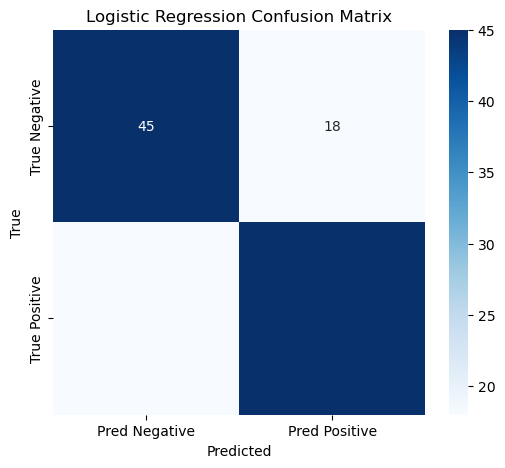

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After getting the best model and making predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Test Accuracy and AUC
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"{best_model_name} Test Accuracy: {test_accuracy:.4f}")
print(f"{best_model_name} Test AUC: {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(report)

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{best_model_name} Confusion Matrix')
plt.show()

### Option2: 2nd set of features & Target

In [26]:
# 2nd set of features and target
selected_features = ['KADJ O', 'KADJ D', 'OPP NET RPI', 'OPP Q1 W', 'OPP Q2 W']  # New features
target_variable = 'SEED'  # New target variable

# Use only selected predictors for training
X_train = train[selected_features]
X_val = val[selected_features]
X_test = test[selected_features]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Target variable (using the new target)
y_train = train[target_variable].astype(int)-1
y_val = val[target_variable].astype(int)-1
y_test = test[target_variable].astype(int)-1

In [27]:
# Define models and hyperparameter grids
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-4, 4, 10),
        "penalty": ["l1", "l2"],
        "solver": ["saga"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 150],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "colsample_bytree": [0.3, 0.7, 1.0],
        "gamma": [0, 1, 5]
    }
}

# Initialize results storage
results = []

In [28]:
# Train each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Perform randomized search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=20,  # Adjust for more thorough search
        scoring='roc_auc',
        cv=3,  # 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train)
    
    # Best parameters
    best_model = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_scaled)
    y_val_proba = best_model.predict_proba(X_val_scaled)  # Get probabilities for each class

    accuracy = accuracy_score(y_val, y_val_pred)
    
    # For multi-class, use 'ovr' for one-vs-rest or 'ovo' for one-vs-one
    auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')

    print(f"{model_name} Validation Accuracy: {accuracy:.4f}")
    print(f"{model_name} Validation AUC: {auc:.4f}")

    # Save results
    results.append({
        "Model": model_name,
        "Best Parameters": random_search.best_params_,
        "Validation Accuracy": accuracy,
        "Validation AUC": auc
    })

# Compare models
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

Training Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Logistic Regression: {'solver': 'saga', 'penalty': 'l1', 'C': 0.0001}
Logistic Regression Validation Accuracy: 0.1190
Logistic Regression Validation AUC: 0.5000
Training Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Random Forest Validation Accuracy: 0.2776
Random Forest Validation AUC: 0.8146
Training XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for XGBoost: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.3}
XGBoost Validation Accuracy: 0.1870
XGBoost Validation AUC: 0.7679

Model Comparison:
                 Model                                    Best Parameters  \
0  Logistic Regression   {'solver': 'saga', 'penalty': 'l1', 'C': 0.000

In [29]:
# Test the best model
best_model_row = results_df.loc[results_df["Validation AUC"].idxmax()]
best_model_name = best_model_row["Model"]
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_model.set_params(**best_model_row["Best Parameters"])
best_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)

# Test Accuracy and AUC
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')

print(f"{best_model_name} Test Accuracy: {test_accuracy:.4f}")
print(f"{best_model_name} Test AUC: {test_auc:.4f}")


Best Model: Random Forest
Random Forest Test Accuracy: 0.2857
Random Forest Test AUC: 0.8336


Random Forest Test Accuracy: 0.2857
Random Forest Test AUC: 0.8336
Confusion Matrix:
[[6 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 5 2 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 4 4 1 0 0 1 1 0 0 1 0 0 0 0 0]
 [5 1 3 1 0 2 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 2 1 1 1 1 0 1 1 2 0 0 0 0]
 [0 3 3 1 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 3 1 0 0 0 0 2 0 0 0 0]
 [0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
 [2 0 0 0 1 2 1 1 0 0 2 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.67      0.41         9
           1       0.31      0.50      0.38        10
           2       0.24      0.31      0.27        13
           3       0.14      0.08      0.11        12
           4       0.33      0.07      0.11        15
      

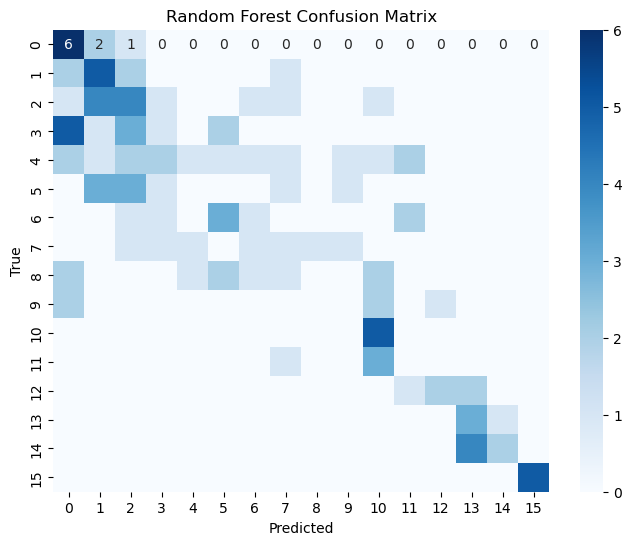

In [30]:
# After getting the best model and making predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)

# For multi-class classification, get probabilities for all classes
y_test_proba = best_model.predict_proba(X_test_scaled)

# Ensure the probabilities are valid for AUC calculation
if y_test_proba.shape[1] == 1:
    # In case we only have probabilities for a binary class, reshape for multi-class
    y_test_proba = np.hstack([1 - y_test_proba, y_test_proba])

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# For multi-class, calculate AUC with multi_class='ovr' (One-vs-Rest)
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')

print(f"{best_model_name} Test Accuracy: {test_accuracy:.4f}")
print(f"{best_model_name} Test AUC: {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(report)

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{best_model_name} Confusion Matrix')
plt.show()

### Option3: 3rd set of features & Target

In [31]:
# Use only selected predictors for training
selected_features = ['SEED', 'KADJ O', 'BADJ EM', 'BARTHAG', 'WAB', 'NET RPI']  # updated list of selected features
X_train = train[selected_features]
X_val = val[selected_features]
X_test = test[selected_features]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Target variable
y_train = train['OUTCOME'].astype(int)
y_val = val['OUTCOME'].astype(int)
y_test = test['OUTCOME'].astype(int)

In [32]:
# Create the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Step 2: Hyperparameter tuning using RandomizedSearchCV
# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.01, 0.1, 1]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', verbose=2, random_state=42)

# Fit the model on the training data
random_search.fit(X_train_scaled, y_train)

# Step 3: Best Model Parameters
best_model = random_search.best_estimator_
print("Best Parameters: ", random_search.best_params_)

# Step 4: Model Evaluation

# Predict on the validation set
y_val_pred = best_model.predict(X_val_scaled)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=300, reg_alpha=0.1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=300, reg_alpha=0.1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=300, reg_alpha=0.1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72       198
           1       0.64      0.72      0.68       155

    accuracy                           0.70       353
   macro avg       0.70      0.70      0.70       353
weighted avg       0.71      0.70      0.70       353

ROC-AUC: 0.7816


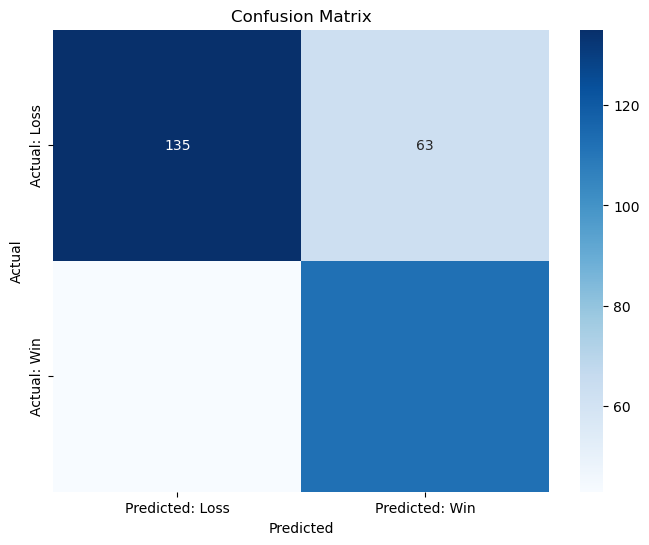

In [33]:
# Classification Report (Precision, Recall, F1-Score, and AUC)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC
y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: Loss', 'Predicted: Win'], yticklabels=['Actual: Loss', 'Actual: Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
# Predict on the test set for final evaluation
y_test_pred = best_model.predict(X_test_scaled)
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

# Display Test Results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.6905
Test ROC-AUC: 0.7453


### Option4: New Features & Target

In [35]:
# Select features and new target
selected_features = ['SEED', 'KADJ EM', 'BARTHAG', 'ELITE SOS', 'H BADJ EM']  # selected feature set
target_variable = 'POOL VALUE'

# Split the dataset into train, validation, and test sets
train, temp = train_test_split(cd, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Prepare features and target
X_train = train[selected_features]
X_val = val[selected_features]
X_test = test[selected_features]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert target to categorical for classification
y_train = pd.qcut(train[target_variable], q=3, labels=[0, 1, 2])  # Categorize into 3 classes
y_val = pd.qcut(val[target_variable], q=3, labels=[0, 1, 2])
y_test = pd.qcut(test[target_variable], q=3, labels=[0, 1, 2])

In [36]:
# Model training with hyperparameter tuning (example: Random Forest)
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model selection
best_model = grid_search.best_estimator_

# Predict on validation set
y_val_pred = best_model.predict(X_val_scaled)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; tota

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       102
           1       0.32      0.10      0.16       107
           2       0.59      0.81      0.68        96

    accuracy                           0.59       305
   macro avg       0.52      0.60      0.53       305
weighted avg       0.52      0.59      0.52       305



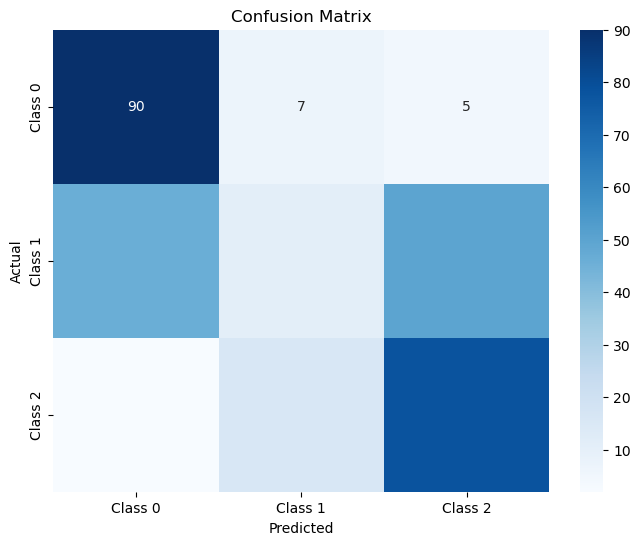

In [37]:
# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [38]:
# Predict on test set
y_test_pred = best_model.predict(X_test_scaled)

# Calculate Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")  # Format for 4 decimal places

# Predict class probabilities
y_test_proba = best_model.predict_proba(X_test_scaled)

# Calculate Test AUC-ROC with 'ovr' strategy
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
print(f"Test AUC-ROC (ovr): {test_auc:.4f}")

Test Accuracy: 0.6569
Test AUC-ROC (ovr): 0.7742
